# SHP2CSV algorithm
## Importing libraries

In [1]:
from shapely.geometry import shape
from shapely.ops import unary_union
import fiona
import networkx as nx
import itertools
import matplotlib.pyplot as plt
from IPython.core.debugger import Tracer
from shutil import copyfile
import pandas as pd

## Importing and reading shp file

In [2]:
geoms =[shape(feature['geometry']) for feature in fiona.open("shp/Bogota_linea/Bogota_linea_holes/Bogota_linea.shp") if feature['geometry'] != None]


## Converting `geoms` into a planar graph

In [3]:
file_info = fiona.open("shp/Bogota_linea/Bogota_linea_holes/Bogota_linea.shp")

In [4]:
res = unary_union(geoms)

## Creating a Graph object in order to print it
this part of the code is not needed, it is just for having an idea of the graph that is going to be exported

In [5]:
G = nx.Graph()
for line in res:
    for seg_start, seg_end in zip(list(line.coords),list(line.coords)[1:]):
        G.add_edge(seg_start, seg_end)

## Plotting the graph

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is dep

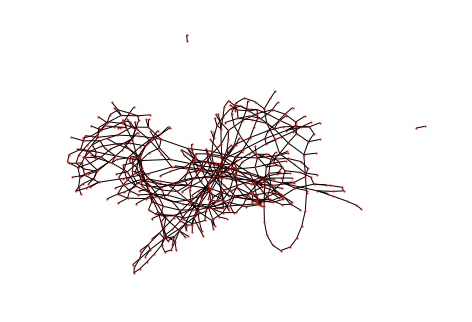

In [6]:
nx.draw(G, node_size=1)
plt.show()

## Creating sets

In [7]:
y = set()
x = set()
lengths = set()

nodes = set()
edges = set()
edges_prime = set()

nodes_norm = list()
edges_norm = set()

## Creating a list of nodes

In [8]:
for line in res:
    for node in line.coords:
        nodes.add((round(node[0],3),round(node[1],3)))
        x.add(round(node[0],3))
        y.add(round(node[1],3))

nodes = list(nodes)

## Normalizing the nodes coordinates

In [9]:
# Getting the max and min for x and y axis
x_max = max(x)
x_min = min(x)
y_max = max(y)
y_min = min(y)

In [10]:
df3 = pd.DataFrame(data=[[x_min,x_max,y_min,y_max]], columns=['x_min','x_max','y_min','y_max'])
df3.to_csv('../../distributions/boundaries.csv', index=False)

In [11]:
# Normalizing

for node in nodes:
    node_norm = (nodes.index(node), [(node[0]-x_min)/(x_max-x_min),(node[1]-y_min)/(y_max-y_min)])
    nodes_norm.append(node_norm)
    
nodes_norm = [(item[0], [round(item[1][0],3), round(item[1][1],3)]) for item in nodes_norm]

## Creating a list of edges

In [12]:
for line in file_info:
    last_coord = None
    for coord in line['geometry']['coordinates']:
        if last_coord != None:
            length = ((coord[0]-last_coord[0])**2+(coord[1]-last_coord[1])**2)**0.5
            edge = ((nodes.index((round(last_coord[0],3),round(last_coord[1],3))),nodes.index((round(coord[0],3),round(coord[1],3)))),length,line['properties']['Id'])
            edges_prime.add(edge)
        last_coord = coord
        
    
edges_prime = [edge for edge in edges_prime if edge[0][1] != edge[0][0]]

In [13]:
nodes_with_capacity = list(zip(*edges_prime))[0]
for line in res:
    last_coord = None
    lenght = len(line.coords)
    for coord in line.coords:
        if last_coord != None:
            capacity = 0
            length = ((coord[0]-last_coord[0])**2+(coord[1]-last_coord[1])**2)**0.5
            nodes_connected = (nodes.index((round(last_coord[0],3),round(last_coord[1],3))),nodes.index((round(coord[0],3),round(coord[1],3))))
            if nodes_connected in nodes_with_capacity:
                capacity = edges_prime[nodes_with_capacity.index(nodes_connected)][2]
            elif (nodes_connected[1],nodes_connected[0]) in nodes_with_capacity:
                capacity = edges_prime[nodes_with_capacity.index((nodes_connected[1],nodes_connected[0]))][2]
            
            edge = (nodes_connected,length,capacity)
            edges.add(edge)
        last_coord = coord
        
    
edges = [edge for edge in edges if edge[0][1] != edge[0][0]]

In [14]:
edges_with_capacity = [edge for edge in edges if edge[2] > 0]
edges_prime_with_capacity = [edge for edge in edges_prime if edge[2] > 0]
edges_ignored = [edge for edge in edges_prime_with_capacity if edge[0] not in list(zip(*edges_with_capacity))[0] and (edge[0][1], edge[0][0]) not in list(zip(*edges_with_capacity))[0]]
print("there is still", len(edges_prime_with_capacity) - len(edges_with_capacity),"(",len(edges_ignored), ")", "edges without correct capacity")
assert len(edges_prime_with_capacity) - len(edges_with_capacity) == len(edges_ignored)


there is still 156 ( 156 ) edges without correct capacity


# Solving new streets capacity (simplify algorithm)
let's define the following sets
* $\bar A$ is a **constant** set (or a duple) o $A$ at the begginning of this algorithm
* $A$ is the set of all nodes in the original map
* $B$ is the set of all nodes in the planar map
* $E_A$ is the set of all edges in the original map
* $E_B$ is the set of all edges in the planar map
* $B-A$ if the set of all nodes in $B$ and not in $A$, i.e. the new nodes
* $E_A'$ and empty set, made of all the edges broken into two parts

El algoritmo es el siguiente:

0. Find set $T=\{(x,w)|x\in A \wedge w\in B-A\}$ 
    1. For each $n\in T$:
        1. We know that $ n\in T \implies \exists n=(x,y), x\in A \wedge y \in B-A $
        2. Find $E_x^A$ (nodes connected to or from $x$ based on $E_A$) that is $E_x^A = \{(x,w)\in E_A\}$
        3. For each $m \in E_x^A$:
            4. Calculate $d(m,y)$ taking into account that $m$ is a segment
        4. set $c(n) = c(l)$ with $d(l,y) \leq d(o,y), \forall o\in E_x^A$ where $l,o$ are edges
        5. remove $l=(x,z)$ from $E_A$ and add it to $E_A'$
        6. add $n$ and $(y,z)$ to $E_A$
        7. recalculate $T$

In [15]:
def d(edge, point):
    return abs((edge[1][1]-edge[0][1])*point[0] - (edge[1][0]-edge[0][0])*point[1]+edge[1][0]*edge[0][1]-edge[1][1]*edge[0][0])/(((edge[1][1]-edge[0][1])**2+(edge[1][0]-edge[0][0])**2)**0.5)


In [16]:
new_ones = set()

In [17]:
import ipdb
# Get A and B and EA and EB
A = set()
EA = set()
EA_p = set()
for line in file_info:
    if line['properties']['Id'] != 0:
        old_coord = None
        for coord in line['geometry']['coordinates']:
            coord = (round(coord[0],3),round(coord[1],3))
            A.add(coord)
            if old_coord != None:
                EA.add((old_coord,coord))
            old_coord = coord
        
B = nodes
EB = list(zip(*edges))[0]
EB = set([(B[node[0]],B[node[1]]) for node in EB])
B_A = set([node for node in B if node not in A])


T = [edge for edge in EB if (edge[0] in A and edge[1] in B_A) or (edge[0] in B_A and edge[1] in A)]
while len(T) > 0:
    #ipdb.set_trace()
    n = T[0]
    if n[1] in B_A:
        y = n[1]
        x = n[0]
    else:
        y = n[0]
        x = n[1]
      
    E_x_A = [edge for edge in EA if x in edge and edge[0] != edge[1]]
    
    minimum_d = float('inf')
    minimum_edge = None
    for m in E_x_A:
        if minimum_d > d(m,y):
            minimum_d = d(m,y)
            minimum_edge = m
            
    z = None
    if minimum_edge[0] == x: z = minimum_edge[1]
    else: z = minimum_edge[0]
        
    A.add(y)
    EA.remove(minimum_edge)
    EA_p.add(minimum_edge)
    EA.add(n)
    EA.add((y,z))
    new_ones.add((n,minimum_edge))
    
    B_A = set([node for node in B if node not in A])
    T = [node for node in EB if (node[0] in A and node[1] in B_A) or (node[0] in B_A and node[1] in A)]

In [18]:
to_change = []
for news in new_ones:
    for line in file_info:
        tmp = line['geometry']['coordinates']
        tmp = [(round(coord[0],3),round(coord[1],3)) for coord in tmp]
        if news[1][0] in tmp and  news[1][1] in tmp :
            to_change.append((list(zip(*edges))[0].index((nodes.index(news[0][0]),nodes.index(news[0][1]))),line['properties']['Id']))
            break

In [19]:
edges2 = []
for edge in edges:
    capacity = edge[2]
    if edges.index(edge) in list(zip(*to_change))[0]:
        capacity = to_change[list(zip(*to_change))[0].index(edges.index(edge))][1]
    edges2.append((edge[0],edge[1],capacity))

In [23]:
edges_old = edges
edges = edges2

## Normalizing the cost of the edges

In [24]:
length_max = max(list(zip(*edges))[1])
length_min = min(list(zip(*edges))[1])

# normalizing length
edges_norm = [(edges.index(edge),edge[0],(edge[1]-length_min)/(length_max-length_min),edge[2]) for edge in edges]

## Exporting results to csv

In [25]:
# Writing csv
import csv

# vertices
with open("vertices.csv", "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in nodes_norm:
        writer.writerow([val[0],val[1][0],val[1][1]])
        
# edges
with open("edges.csv", "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in edges_norm:
        writer.writerow([val[0], val[1][0], val[1][1], val[2], val[3]])

copyfile('edges.csv', '../../streets/edges.csv');
copyfile('vertices.csv', '../../streets/vertices.csv');